# Case 1: One transmitter and one receiver.

(Article: Look-Ahead and Learning Approaches for Energy Harvesting Communications Systems)

## Q-Learning Approach

In [33]:
import numpy as np
import matplotlib.pyplot as plt

Step 1. Define problem

Point-to-point communication, one source (S) and one destination (D).
S has infinite buffer to store data, finite battery Bmax, Bi battery levels. (Cuantizada)

Model parameters:

In [34]:
# Time slotted system. Each time slot (Ts) is 1s duration. 
Tc = 1

# Bandwith
BW = 1 # MHz
# Noise Spectral density 
sigma_n2 = 1e-9 # W/Hz 

# B is the Battery capacity. B_max is the maximum capacity. 
# Nb is the number of 'slots' in B (Quantized battery).
B_max = 12 #units
B_levels = list(range(B_max + 1)) 

# Energy harvested:
Eh = 0.05 #J es la unidad básica. Esto es 1 unidad de la batería. 
EH_levels = np.linspace(0,0.25,6)
#print(EH_levels)
energy_levels = [0, 1, 2, 3, 4, 5]     # unidades discretas (Niveles de energía como de batería)
# P son las acciones: Puedes transmitir tanta potencia como batería (o menos).
# P_levels = EH_levels   

# Transition Energy Probability Matrix
E_tm = np.array([
      [0.4011, 0.3673, 0.1027, 0.0899, 0.0279, 0.0111],
      [0.4072, 0.3441, 0.1002, 0.0973, 0.0305, 0.0207],
      [0.3966, 0.3239, 0.1165, 0.0860, 0.0400, 0.0370],
      [0.3796, 0.3272, 0.1158, 0.0782, 0.0514, 0.0478],
      [0.3612, 0.3451, 0.1055, 0.0837, 0.0501, 0.0544],
      [0.3711, 0.3341, 0.1107, 0.0801, 0.0502, 0.0538]])

# Channel states:
H_states = np.linspace(0,-20,11) # In dB. 
# Random transition probabilities between them.
H_linear = 10 ** (H_states / 10)
print(H_linear)
H_idxs = list(range(len(H_linear) )) 

#print(H_linear)

# Start at B = 0, H = rand, EH = rand (With seed for replicability)
np.random.seed(2025)
# start = (B_levels[0],np.random.randint(0, len(H_linear)),np.random.randint(0, len(energy_levels)))
start = (np.random.randint(0, len(B_levels)),np.random.randint(0, len(H_linear)),np.random.randint(0, len(EH_levels)))
print(start)

[1.         0.63095734 0.39810717 0.25118864 0.15848932 0.1
 0.06309573 0.03981072 0.02511886 0.01584893 0.01      ]
(2, 8, 3)


Step 2. Define RL Parameters and initialize Q-Table (Table of Rewards):

In [35]:
# num_episodes: Number of times the agent will attempt to navigate the maze.
num_episodes = 1000

# Tiempo por episodio
total_time=500

# alpha: Learning rate that controls how much new information overrides old information.
alpha = 0.1
# gamma: Discount factor giving more weight to immediate rewards.
gamma = 0.9

# e-greedy algorithm variables
# (i is the time slot number in an episode) 
# ¿Parece que explora más a medida que avanza el tiempo?
def explorationProbability(i):
    return np.exp(-0.001*i)

# actions are the P levels avalilable.
actions = B_levels #pero en unidades

# Q is the Q-Table initialized to zero; it stores expected rewards for each state-action pair.
Q = np.zeros((len(B_levels),)+(len(H_linear),)+(len(EH_levels),)+(len(actions),)) # Q.shape = [9,9,4]
print(Q.shape)

(13, 11, 6, 13)


Valid actions:

In [36]:
def get_valid_actions(state):
    E_overflow = max(state[0]+min(state[2],B_max)-B_max,0)
    available_actions = state[0]
    valid_actions = [
        a for a in actions
        if E_overflow <= Tc*a <= available_actions
    ]
    return valid_actions

# Devuelve el valor de valid_actions (índices) que es máximo en Q[state].
def get_Q_max_action(valid_actions,state):
    return int(max(valid_actions, key=lambda a: Q[state][a]))

def explotation_vs_exploration(state, epsilon):
    valid_actions = get_valid_actions(state)
    if np.random.random() < epsilon:
        #Exploration (Probability e)
        return int(np.random.choice(valid_actions))
    else: 
        #Explotation (Probability 1-e)
        return get_Q_max_action(valid_actions, state)
    
# Esta se debería de quitar
def constraints(P_i,B_i,EH_i):
    E_overflow = max(B_i+min(EH_i,B_max)-B_max,0)
    return Tc*P_i <= B_i and P_i >= 0 and B_i >= 0 and P_i >= E_overflow


Reward function:
(Amount of received data)

In [37]:
def RewardFunction(power_idx, h_idx):
    Power_i = actions[power_idx]
    #Power_i_J = Power_i*0.05 # en J No se si es en unidades o Julios
    Hi = H_linear[h_idx]
    #return Tc*np.log2(1+(Power_i*(Hi**2))/sigma_n2)
    Rward = Tc*np.log2(1+Power_i*Hi**2/sigma_n2)
    #print(Rward)
    return Rward

def sample_from_PE(e_current_idx):
    probs = E_tm[e_current_idx]
    return np.random.choice(len(energy_levels), p=probs)

def sample_from_PH():
    return int(np.random.choice(H_idxs))

Step 4: Train the Agent with Q-Learning Algorithm 

In [38]:
rewards_all_episodes = []

for episode in range(num_episodes):
    total_rewards = 0
    state = start
    for time in range(total_time):
        #escoger una acción desde el estado actual.
        B_idx, H_idx,  EH_idx= state
        
        #action_index = choose_action(state, time, total_time)
        epsilon = 0.2
        action_index = explotation_vs_exploration(state, epsilon)
        is_valid = constraints(action_index, B_idx,EH_idx)

        # las acciones disponibles dependen del estado. 
        # (En este caso es así)
        # Así q en choose_action solo puede escoger dentro de los niveles de batería.
        while not is_valid:
            # Creo q no puede ocurrir que no sea válida #MIRAR ESTO
            print("Warning: Acción no válida. Recalculando.")
            #action_index = choose_action(state, time, total_time)
            action_index = explotation_vs_exploration(state, epsilon)
            is_valid = constraints(action_index, B_idx,EH_idx)

        # Luego actualizar el estado siguiente. 
        # habrá que escoger un H aleatoriamente
        # después un EH según la matriz de probabilidad.
        # después actualizar con EH la batería, que tendrá un máximo.
       
        if is_valid:
            reward = RewardFunction(action_index, H_idx)

            next_B = min(B_idx + EH_idx - Tc*action_index, B_max)
            next_H = sample_from_PH()
            next_EH = sample_from_PE(EH_idx) # Esto es del modelo, no de Q-learning.
            # ¿Habría q mirar aquí lo del overflow?

            next_state = (next_B, next_H, next_EH)

            old_value = Q[state][action_index]
            #print(next_state)
            #print(action_index)
            next_max = max(Q[next_state])

            Q[state][action_index] += alpha*(reward + gamma*next_max - old_value)
            state = next_state
            total_rewards += reward
            
        else:
            print("ERROR: La acción debería ser válida. ")
    
    # En el laberinto, se actualiza epsilon. Aquí no lo sé. 
    rewards_all_episodes.append(total_rewards)

        # En base a la P transmitida escogida en action_index devolverá una recompensa.
        # Con esa recompensa, actualizar la matriz Q.

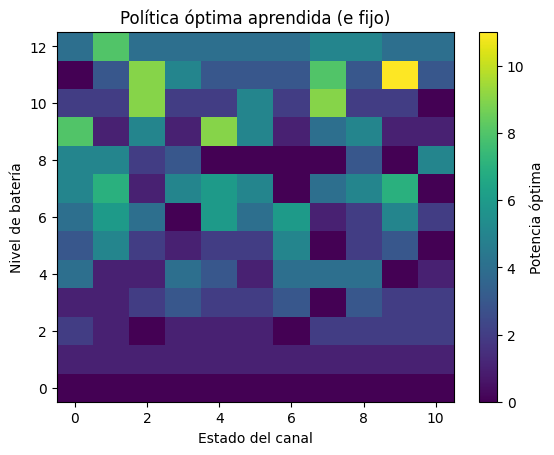

In [39]:
policy = np.zeros((len(B_levels), len(H_states)))

e_idx = 4
best_action = None
best_value = -float('inf')

for b in range(len(B_levels)):
    for h in range(len(H_states)):
        q_vals = Q[b, h, e_idx, :]
        policy[b, h] = actions[np.argmax(q_vals)]
plt.imshow(policy, origin='lower', aspect='auto')
plt.colorbar(label='Potencia óptima')
plt.xlabel('Estado del canal')
plt.ylabel('Nivel de batería')
plt.title('Política óptima aprendida (e fijo)')
plt.show()

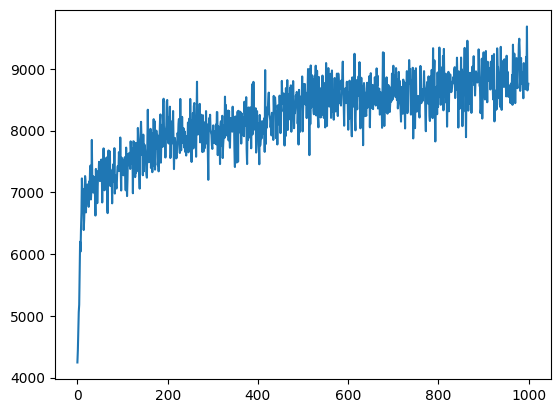

In [42]:
plt.plot(range(num_episodes), rewards_all_episodes)

In [41]:

""" for time in range(total_time):
    #Para cada unidad de tiempo, de todas las acciones posibles
    for possible_actions in range(actions): """

' for time in range(total_time):\n    #Para cada unidad de tiempo, de todas las acciones posibles\n    for possible_actions in range(actions): '